In [1]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("mexwell/tea-sickness-dataset")

print("Path to dataset files:", path)

100%|██████████| 740M/740M [00:05<00:00, 130MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mexwell/tea-sickness-dataset/versions/1


In [19]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [23]:
# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# We use MobileNetV3-Small because it is designed specifically for mobile CPUs.
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = '/root/.cache/kagglehub/datasets/mexwell/tea-sickness-dataset/versions/1/tea-sickness-dataset'
final_data_dir = DATA_DIR

In [26]:
# ==========================================
# 2. DATA PIPELINE (AUGMENTATION)
# ==========================================
# Industrial grading needs robustness against lighting/rotation.
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# NOTE: We use final_data_dir here!
train_generator = train_datagen.flow_from_directory(
    final_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    final_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)

Found 711 images belonging to 8 classes.
Found 174 images belonging to 8 classes.


In [28]:
# ==========================================
# 3. MODEL ARCHITECTURE (TRANSFER LEARNING)
# ==========================================
# Using the "Small" variant for edge efficiency.
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [48]:
# ==========================================
# 4. TRAINING
# ==========================================
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Optional: Fine-tuning (Unfreeze top layers)
# base_model.trainable = True
# model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_generator, epochs=2, validation_data=val_generator)


Starting training...
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.7506 - loss: 0.7896 - val_accuracy: 0.6782 - val_loss: 0.9402
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7406 - loss: 0.7657 - val_accuracy: 0.6954 - val_loss: 0.9239
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7830 - loss: 0.6749 - val_accuracy: 0.6379 - val_loss: 0.8773
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8033 - loss: 0.6314 - val_accuracy: 0.6667 - val_loss: 0.8550
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8218 - loss: 0.5870 - val_accuracy: 0.7414 - val_loss: 0.8105
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7922 - loss: 0.6174 - val_accuracy: 0.7126 - val_loss: 0.8186
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8101 - loss: 0.5592 - val_accuracy: 0.7299 - val_loss: 0.7728
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8146 - loss: 0.5664 - val_accurac


FINAL TRAINING RESULTS
Final Training Accuracy:   83.40%
Final Validation Accuracy: 69.54%


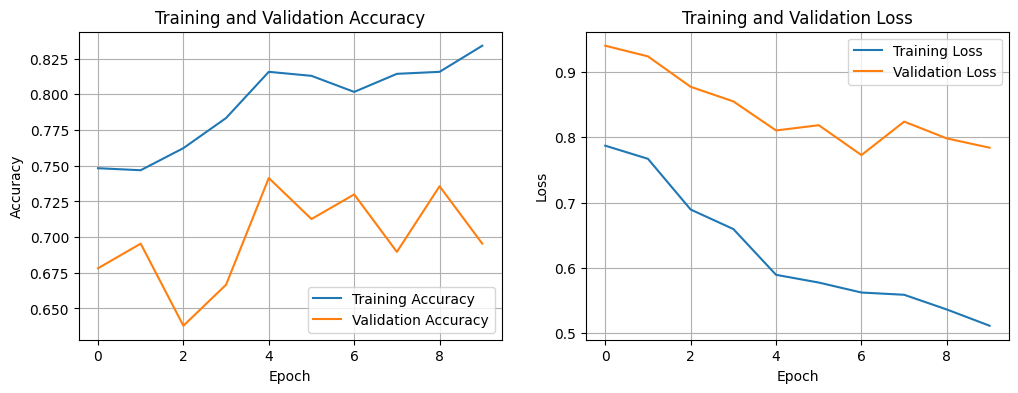

In [50]:
# ==========================================
# 5. EVALUATION & RESULTS
# ==========================================
# 1. Retrieve the results from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Get the specific values for the FINAL epoch
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]

print("\n" + "="*30)
print("FINAL TRAINING RESULTS")
print("="*30)
print(f"Final Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print("="*30)

# 3. Optional: Plot the training curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [36]:
# RECOVER CLASS NAMES
# If train_generator still exists in memory, we can pull the names from it
try:
    class_indices = train_generator.class_indices
    # Invert the dictionary to map {0: 'anthracnose'}
    class_names = {v: k for k, v in class_indices.items()}
    # Convert to a list if your code expects a list (e.g., class_names[0])
    class_names_list = list(class_indices.keys())
    print(f"Recovered classes: {class_names_list}")

    # Update the lookup to use the dictionary or list depending on how you use it
    # Your code uses: class_names[index], so let's make sure it works:
    class_names = class_names_list

except NameError:
    print("CRITICAL: 'train_generator' is also missing.")
    print("Please go back up and run the cell starting with: 'train_datagen = ImageDataGenerator(...)'")

Recovered classes: ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

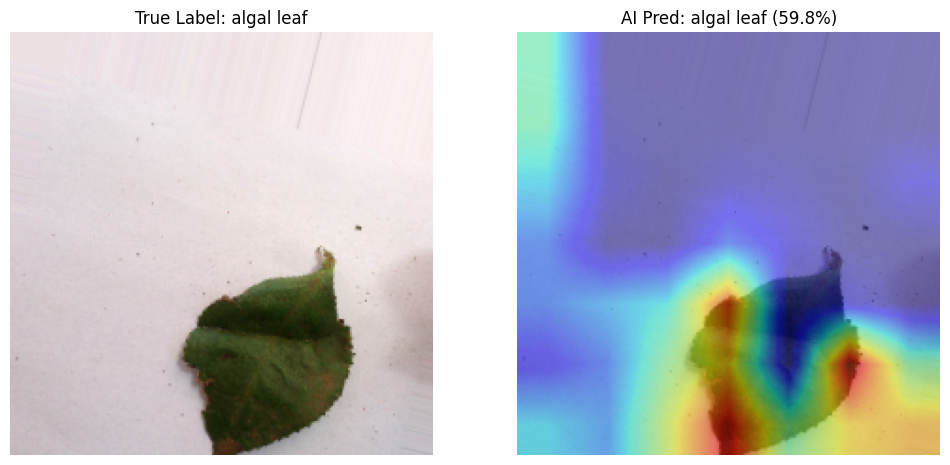

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Helper to normalize images for display
def safe_display_image(img):
    img = img - np.min(img)
    img = img / (np.max(img) + 1e-7)
    return img

# 1. AUTO-DETECT LAST CONV LAYER
last_conv_layer_name = None
for layer in reversed(model.layers):
    if 'Conv2D' in layer.__class__.__name__:
        last_conv_layer_name = layer.name
        break

if not last_conv_layer_name:
    last_conv_layer_name = 'Conv_1'

# 2. GRAD-CAM FUNCTION
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 3. GENERATE & PLOT

# Get the Prediction explicitly
x_batch, y_batch = next(val_generator)
sample_img = x_batch[0]
true_label = class_names[np.argmax(y_batch[0])]

# Ask model to predict
preds = model.predict(np.expand_dims(sample_img, axis=0))
pred_index = np.argmax(preds[0])
pred_label = class_names[pred_index]
confidence = np.max(preds[0]) * 100

# Re-Generate Heatmap
heatmap = make_gradcam_heatmap(np.expand_dims(sample_img, axis=0), model, last_conv_layer_name)

# Plot with the NEW Titles
plt.figure(figsize=(12, 6))

# Left: Truth
plt.subplot(1, 2, 1)
plt.title(f"True Label: {true_label}")
plt.imshow(safe_display_image(sample_img))
plt.axis('off')

# Right: Prediction + Heatmap
plt.subplot(1, 2, 2)
plt.title(f"AI Pred: {pred_label} ({confidence:.1f}%)")
plt.imshow(safe_display_image(sample_img))
heatmap_resized = cv2.resize(heatmap, (224, 224))
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

In [52]:
import os
import tensorflow as tf

# ==========================================
# 6. DEPLOYMENT: QUANTIZATION (The Edge AI Part)
# ==========================================

# Save the Original Model (Baseline)
# We use .keras or .h5 to get the full training size
original_filename = 'tealeaf_lens_original.h5'
model.save(original_filename)

# Convert to TFLite with Quantization
print("Converting model to TFLite (Int8 Quantization)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Enable Dynamic Range Quantization
tflite_quant_model = converter.convert()

# Save the Quantized TFLite File
tflite_filename = 'tealeaf_lens.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

# Calculate Final Stats
original_size_mb = os.path.getsize(original_filename) / (1024 * 1024)
tflite_size_mb = os.path.getsize(tflite_filename) / (1024 * 1024)
compression_ratio = original_size_mb / tflite_size_mb

# Print the "Resume Stats"
print("\n" + "-" * 40)
print(f"FINAL MODEL SIZE REPORT")
print("-" * 40)
print(f"Original Model (.h5):    {original_size_mb:.2f} MB")
print(f"Edge AI Model (.tflite): {tflite_size_mb:.2f} MB")
print(f"Compression Ratio:    {compression_ratio:.1f}x smaller")
print("-" * 40)

Converting model to TFLite (Int8 Quantization)...
Saved artifact at '/tmp/tmpzl2yk5me'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_534')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133392580466384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580467152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580467920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580467536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580467728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580466192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580466960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580465232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580466768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133392580468880: TensorSpec(sh